# Project 3: Analyze A/B Test Results
## by Yash Viras

### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

### Part I - Probability

In [1]:
#Importing libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read the `test.csv` dataset. Store it in `DataFrame`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
DataFrame = pd.read_csv('test.csv')
DataFrame.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Below cell to find the number of rows in the dataset.

In [3]:
len(DataFrame.index)

294478

c. Unique users in dataset.

In [4]:
DataFrame.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
len(DataFrame.query('converted==1'))/len(DataFrame.index)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
group1 = len(DataFrame.query('group!="treatment" and landing_page=="new_page"'))
group2 = len(DataFrame.query('group!="control" and landing_page=="old_page"'))
group=group1+group2
group

3893

f. To check for missing values.

In [7]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No missing Values**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [8]:
DataFrame2=DataFrame

In [9]:
DataFrame2 = DataFrame[((DataFrame.group=='treatment') & (DataFrame.landing_page=='new_page')) | ((DataFrame.group=='control') & (DataFrame.landing_page=='old_page'))]

In [10]:
DataFrame2[((DataFrame2['group'] == 'treatment') == (DataFrame2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **DataFrame2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **DataFrame2**?

In [11]:
DataFrame2.user_id.nunique()

290584

b. There is one **user_id** repeated in **DataFrame2**.  What is it?

In [12]:
DataFrame2.user_id[DataFrame2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
DataFrame2.loc[DataFrame2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **DataFrame2**.

In [14]:
DataFrame2 = DataFrame2.drop_duplicates()

In [15]:
sum(DataFrame2.duplicated())

0

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
DataFrame2['converted'].mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_group = len(DataFrame2.query('group=="control" and converted==1'))/len(DataFrame2.query('group=="control"'))
control_group

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_group = len(DataFrame2.query('group=="treatment" and converted==1'))/len(DataFrame2.query('group=="treatment"'))
treatment_group

0.11880724790277405

d. What is the probability that an individual received the new page?

In [19]:
len(DataFrame2.query('landing_page=="new_page"'))/len(DataFrame2.index)

0.5000636646764286

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Probability of individual converting given individual is in control group is 0.1203863045004612. Probability of individual converting given individual is in treatment group is 0.11880724790277405. According to the analysis this is clear that there is no more conversion between new page and old page. As the converting rate is similar in both cases so it is important to consider other factors.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that no page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **test.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **test.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = len(DataFrame2.query( 'converted==1'))/len(DataFrame2.index)
p_new

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = len(DataFrame2.query('converted==1'))/len(DataFrame2.index)
p_old

0.11959667567149027

In [22]:
p=np.mean([p_old,p_new])
p

0.11959667567149027

In [23]:
p_diff=p_new-p_old

#### Under null p_old is equal to p_new

c. What is $n_{new}$?

In [24]:
n_new = len(DataFrame2.query('landing_page=="new_page"'))
n_new

145311

d. What is $n_{old}$?

In [25]:
n_old = len(DataFrame2.query('landing_page=="old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
obs_diff= new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.0005122176688761026

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
p_diffs=[]
new_convert=np.random.binomial(n_new, p_new, 10000)/n_new
old_convert=np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs=new_convert-old_convert

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0, 0.5, 'Count')

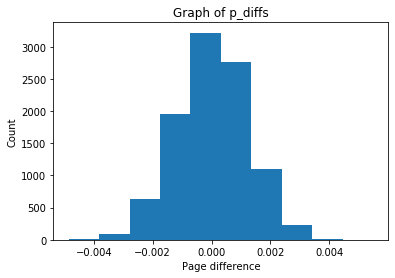

In [30]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)
plt.title('Graph of p_diffs')
plt.xlabel('Page difference')
plt.ylabel('Count')

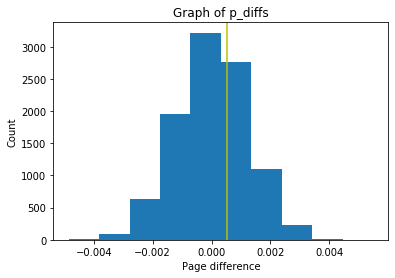

In [31]:
#histogram of p_diff
plt.hist(p_diffs);

plt.title('Graph of p_diffs') #title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

plt.axvline(x= obs_diff, color='y');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **test.csv**?

In [32]:
var1 = DataFrame2[DataFrame2['landing_page'] == 'new_page']
var1=var1['converted'].mean()
var2 = DataFrame2[DataFrame2['landing_page'] == 'old_page']
var2 = var2['converted'].mean()
actual_diff = var1-var2
count = 0
for i in p_diffs:
    if i> actual_diff:
        count = count+1
        
print (count/(len(p_diffs)))

0.9098


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value calculated is called p-value. For accepting null hypothesis p-value should be greater than suggested p-value. Wr calculate that almost 90% of the population is above the real diffrence which suggested that new-page is not doing significantly better than the old page. New page is worse than old page, so we should stick to the null hyposthesis as p-value is large.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = len(DataFrame2.query('converted==1 and landing_page=="old_page"')) 
convert_new = len(DataFrame2.query('converted==1 and landing_page=="new_page"'))
n_old = len(DataFrame2.query('landing_page=="old_page"'))
n_new = len(DataFrame2.query('landing_page=="new_page"'))
n_new

145311

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
#Computing z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#display z_score and p_value
print(z_score,p_value)

1.3116075339133115 0.905173705140591


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [35]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.905173705140591

In [36]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

**z_score is less than critical value of 95% confidence. Hence we fail to reject null hypothesis. Therefore the conclusion is same as part j that we accept null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
#adding an intercept column
DataFrame2['intercept'] = 1

#Create dummy variable column
DataFrame2['ab_page'] = pd.get_dummies(DataFrame2['group'])['treatment']

DataFrame2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
import statsmodels.api as sm
model=sm.Logit(DataFrame2['converted'],DataFrame2[['intercept','ab_page']])
results=model.fit() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Apr 2020   Pseudo R-squ.:               8.085e-06
Time:                        10:54:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**In Logistic regression**

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} != 0$$
**Part 2**
$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Answer:-

We should consider other factors into the regression model as they might influence the conversions too. For instance student segments [new v/s returning candidates] might create change aversion or even, the opposite as a predisposition to conversion. Seasonality like new terms or New years might mean more interest in new skills/ resolutions. Timestamps are inlcuded but without regionality, they do not indicate if seasonality was a factor or not. [as different countries follow different term and weather patterns.

Factors like device on which tests were taken or course which was looked at, prior academic background, age, might alter experience and ultimately, conversions. These are limitations which should be at least kept in mind while making the final decision.

The disadvantages to adding additional terms into the regression model is that even with additional factors we can never account for all influencing factors or accomodate them. Plus, small pilots and pivots sometimes work better in practice than long-drawn 
research without execution.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries = pd.read_csv('./countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
new = countries.set_index('user_id').join(DataFrame2.set_index('user_id'), how = 'inner')
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [42]:
new[['US', 'UK']] = pd.get_dummies(new['country'])[['US', "UK"]]
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0


In [43]:
new['US_ab_page'] = new['US']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1


In [44]:
new['UK_ab_page'] = new['UK']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1,0


In [45]:
logit3 = sm.Logit(new['converted'], new[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'US_ab_page']])
logit3

In [46]:
result3 = logit3.fit()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


h. We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
logit3 = sm.Logit(new['converted'], new[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'US_ab_page']])
result3 = logit3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            4
Date:                Mon, 13 Apr 2020   Pseudo R-squ.:               2.590e-05
Time:                        10:55:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2388
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0366      0.028    -72.618      0.000      -2.092      -1.982
ab_page       -0.0018      0.021     -0.086      0.931      -0.043       0.039
US             0.0501      0.030      1.691      0.091      -0.008       0.108
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US_ab_page    -0.0094   2.37e+06  -3.96e-09      1.000   -4.64e+06    4.64e+06
US_ab_page    -0.0094   2.37e+06  -3.96e-09      1.000   -4.64e+06    4.64e+06
==============================================================================
"""

### Conclusions:
By doing analysis it is proved that old pages are better than new pages, as it is shown in histograam.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_AB_test.ipynb'])

0